<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/profile_models/bpnet_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip uninstall -y keras
!pip install keras==2.2.4 #Keras v 2.3 has a major bug in the reporting of validation loss for models with multiple outputs

TensorFlow 1.x selected.
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 317kB 4.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
!apt-get install bedtools
!pip install pyfaidx
!pip install pyBigWig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 2s (304 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...
  Created wheel for pyfaidx: filename=pyfaidx-0.5.9.2-cp36-none-any.whl size=25139 sha256=c7374884b2103a0e8ee8baa55b75a459b69686dabf0c1e46860a60364e72b77a
  Stored in directory: /root/.cache/pip/wheels/be/36/ce/a716e9b670c54ffb3517e12e1dd89b4da41f34eaecabae485e
Successfully built pyfaid

In [3]:
!wget http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes -O mm10.chrom.sizes

--2021-02-21 04:18:28--  http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1405 (1.4K)
Saving to: ‘mm10.chrom.sizes’

mm10.chrom.sizes    100%[===================>]   1.37K  --.-KB/s    in 0s      

2021-02-21 04:18:28 (241 MB/s) - ‘mm10.chrom.sizes’ saved [1405/1405]



In [4]:
#Get 1000bp around summit
#Example for Sox2, same could be done with Oct4, Nanog, and Klf4
!wget http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/Oct4/idr-optimal-set.summit.bed.gz -O idr-optimal-set.summit.bed.gz 
    
!zcat idr-optimal-set.summit.bed.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g mm10.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > bpnet_Oct4_1k_around_summits.bed.gz    
![[ -f bpnet_Oct4_test_1k_around_summits.bed.gz ]] || zcat bpnet_Oct4_1k_around_summits.bed.gz     | egrep -w 'chr2|chr3|chr4' | gzip -c > bpnet_Oct4_test_1k_around_summits.bed.gz
![[ -f bpnet_Oct4_valid_1k_around_summits.bed.gz ]] || zcat bpnet_Oct4_1k_around_summits.bed.gz     | egrep -w 'chr1|chr8|chr9' | gzip -c > bpnet_Oct4_valid_1k_around_summits.bed.gz
![[ -f bpnet_Oct4_train_1k_around_summits.bed.gz ]] || zcat bpnet_Oct4_1k_around_summits.bed.gz     | egrep -w -v 'chr1|chr2|chr3|chr4|chr8|chr9' | gzip -c > bpnet_Oct4_train_1k_around_summits.bed.gz

--2021-02-21 04:18:28--  http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/Oct4/idr-optimal-set.summit.bed.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208760 (204K) [application/x-gzip]
Saving to: ‘idr-optimal-set.summit.bed.gz’

idr-optimal-set.sum 100%[===================>] 203.87K   489KB/s    in 0.4s    

2021-02-21 04:18:29 (489 KB/s) - ‘idr-optimal-set.summit.bed.gz’ saved [208760/208760]



In [5]:
!mkdir patchcap
!mkdir Oct4

!wget http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/patchcap/counts.neg.bw -O patchcap/counts.neg.bw
!wget http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/patchcap/counts.pos.bw -O patchcap/counts.pos.bw

!wget http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/Oct4/counts.neg.bw -O Oct4/counts.neg.bw
!wget http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/Oct4/counts.pos.bw -O  Oct4/counts.pos.bw

![[-e mm10_no_alt_analysis_set_ENCODE.fasta ]] || wget http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/mm10_no_alt_analysis_set_ENCODE.fasta -O mm10_no_alt_analysis_set_ENCODE.fasta

--2021-02-21 04:18:30--  http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/patchcap/counts.neg.bw
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160921957 (153M)
Saving to: ‘patchcap/counts.neg.bw’

patchcap/counts.neg 100%[===================>] 153.47M  21.1MB/s    in 8.3s    

2021-02-21 04:18:39 (18.6 MB/s) - ‘patchcap/counts.neg.bw’ saved [160921957/160921957]

--2021-02-21 04:18:39--  http://mitra.stanford.edu/kundaje/avanti/bpnet/trainingdata/bpnet_data/patchcap/counts.pos.bw
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160925907 (153M)
Saving to: ‘patchcap/counts.pos.bw’

patchcap/counts.pos 100%[===================>] 153.47M  19.9MB/s    i

In [6]:
![[ -e seqdataloader ]] && rm -rf seqdataloader
!git clone https://github.com/kundajelab/seqdataloader.git
%cd seqdataloader
!pip uninstall seqdataloader
!pip install .
%cd ..

Cloning into 'seqdataloader'...
remote: Enumerating objects: 1675, done.
remote: Total 1675 (delta 0), reused 0 (delta 0), pack-reused 1675
Receiving objects: 100% (1675/1675), 4.02 MiB | 3.16 MiB/s, done.
Resolving deltas: 100% (1043/1043), done.
/content/seqdataloader
Processing /content/seqdataloader
     |████████████████████████████████| 204kB 4.2MB/s 
     |████████████████████████████████| 12.5MB 18.3MB/s 
     |████████████████████████████████| 13.0MB 24.7MB/s 
     |████████████████████████████████| 10.0MB 18.2MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for seqdataloader: filename=seqdataloader-1.2-cp36-none-any.whl size=38616 sha256=3f32f099b0b13ee2c870f457cbb8c9aac3067cf4b52fa3f7ae07c6dea23d9e3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ipyksrew/wheels/c2/db/13/112d41662f69fb8c7986c218293570cc1550fc21eed966e31b
  Created wheel for deeptools: filename=deepTools-3.5.0-cp36-none-any.wh

In [7]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from seqdataloader.batchproducers.coordbased.coordstovals.core import CoordsToValsJoiner
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import AbstractCountAndProfileTransformer 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import LogCountsPlusOne
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import SmoothProfiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import BigWigReader 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import smooth_profiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import rolling_window
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import MultiTrackCountsAndProfile
import keras
import keras.layers as kl
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers.coordbased.core import Coordinates, KerasBatchGenerator, apply_mask
from keras.models import load_model
import os
from keras.utils import CustomObjectScope
from seqdataloader.batchproducers.coordbased.core import Coordinates

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
#Written by Žiga Avsec
import pyBigWig

#loss function
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#Written by Žiga Avsec
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [9]:
# If we want to avoid zero-padding, then the size of the output predictions
# will depend on the size of the input sequence supplied. We define the
# API for an AbstractProfileModel class which returns the length of the
# output profile in addition to returning the model, given information
# on the size of the input sequence and the model parameters.
        
class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()

# The architecture by Žiga Avsec involves residual connections, which means
# that the layers being added together in an elementwise fashion need
# to have the same dimensions. To achieve this without zero-padding, we
# have to trim away the flanks of earlier convolutional layers. That
# is what this function is meant to do. (Note that the original BP-net
# architecture zero-pads; this is a modification to avoid the zero
# padding and use information on actual sequence instead)
def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer


class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()

#This model architecture is based on BP-Net by Žiga Avsec
#It has been modified for this specific use-case.
class BPnetArch(AbstractProfileModel):   

    def __init__(self, counts_loss,
                       counts_hiddenlayer_size,
                       input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr,
                       seed=1234):
        self.counts_loss = counts_loss
        self.counts_hiddenlayer_size = counts_hiddenlayer_size
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr
        self.seed = seed
    
    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len
    
    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len
    
    def get_keras_model(self):
      
        np.random.seed(self.seed)
        tf.set_random_seed(self.seed)

        out_pred_len = self.get_output_profile_len()
        
        #'inp' is the one-hot encoded DNA sequence input
        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = kl.Conv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        
        #Need to keep track of the layer size for trimming purposes when
        # we get to the residual connections.        
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        
        #Define input layers for the control tracks - both counts and profile
        #Dimension is '1' for the ChIP-seq control counts because the positive
        # and negative strands are added together
        patchcap_logcount = kl.Input(
            shape=(2,), name="patchcap.logcount")
        
        patchcap_profile = kl.Input(
            shape=(out_pred_len, 2), name="patchcap.profile")
        
        #Gather together all the tensors representing the model inputs
        model_inputs = [
            inp,
            patchcap_logcount,
            patchcap_profile
        ]
        
        #Prepare the stack of dilated convolutions with residual connections
        prev_layer = first_conv
        for i in range(1, self.n_dil_layers + 1):
            dilation_rate = 2**i
            conv_output = kl.Conv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_layer)          
            width_to_trim = dilation_rate*(self.dil_kernel_size-1)
            curr_layer_size = (curr_layer_size - width_to_trim)
            prev_layer = trim_flanks_of_conv_layer(
              conv_layer=prev_layer, output_len=curr_layer_size,
              width_to_trim=width_to_trim, filters=self.filters)
            prev_layer = kl.merge.Add()([prev_layer, conv_output])

        combined_conv = prev_layer

        #gap = GlobalAveragePooling. This layer is used as input for the
        # counts prediction tasks.
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        
        lossarr = []
        lossweightsarr = []
        model_outputs = []
    
        #Define the output layer for the counts prediction tasks
        precount_out = kl.concatenate([gap_combined_conv, patchcap_logcount],
                                      axis=-1)
        if (self.counts_hiddenlayer_size is not None):
            precount_out = kl.Dense(
                units=self.counts_hiddenlayer_size,
                activation="relu")(precount_out)
        count_out = kl.Dense(
            units=2,
            name="logcount",
            activation="linear")(precount_out)
        model_outputs.append(count_out)
        lossarr.append(self.counts_loss)
        lossweightsarr.append(self.c_task_weight)

        profile_out_precontrol = kl.Conv1D(
                                  filters=2,
                                  kernel_size=self.outconv_kernel_size,
                                  padding='valid')(combined_conv)
        profile_out = kl.Conv1D(filters=2, kernel_size=1,
                                name="profile")(kl.concatenate(
                          [profile_out_precontrol,patchcap_profile], axis=-1))
        model_outputs.append(profile_out)
        lossarr.append(MultichannelMultinomialNLL(2))
        lossweightsarr.append(1)

        #Compile the model and return it
        model = keras.models.Model(inputs=model_inputs, outputs=model_outputs)
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=lossarr,
                      loss_weights=lossweightsarr)
        return model

seq_len = 1346
out_pred_len = 1000
#out_pred_len = modelwrapper.get_output_profile_len()
#print(out_pred_len, seq_len-out_pred_len)   
    
    
# the code below is used to prepare instances of keras.utils.Sequence that
# can be supplied to model.fit_generator(...)
# Note that we log-transform our counts using np.log(counts+1)
# Also note that the profiles for the control are smoothed by windows of
# size 1 and 50 (smoothing by a window of size 1 just returns
# the original profile)
inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="mm10_no_alt_analysis_set_ENCODE.fasta",
        mode_name="sequence",
        center_size_to_use=seq_len),
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="patchcap.logcount",
        profile_mode_name="patchcap.profile",
        pos_strand_bigwig_path="patchcap/counts.pos.bw",
        neg_strand_bigwig_path="patchcap/counts.neg.bw",
        center_size_to_use=out_pred_len),
    ]
)
    

targets_coordstovals = coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name="logcount",
        profile_mode_name="profile",
        pos_strand_bigwig_path="Oct4/counts.pos.bw",
        neg_strand_bigwig_path="Oct4/counts.neg.bw",
        center_size_to_use=out_pred_len)

keras_train_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="bpnet_Oct4_train_1k_around_summits.bed.gz",
      batch_size=64,
      shuffle_before_epoch=True, 
      seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals,
  coordsbatch_transformer=
          coordbatchtransformers.ReverseComplementAugmenter().chain(
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="mm10.chrom.sizes")),
)

keras_valid_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="bpnet_Oct4_valid_1k_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals
)

#As a sanity check, print out the dimensions of everything in individual batches
sampinputs,samptargets = keras_train_batch_generator[0]
# for key in sampinputs:
#   print(key, sampinputs[key].shape)
for key in samptargets:
    print(key, samptargets[key].shape)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
logcount (128, 2)
profile (128, 1000, 2)


In [10]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt


def extend_generator(generator):
    samp_inputs, samp_targets = generator[0]
    concat_inputs = OrderedDict([(key, []) for key in samp_inputs.keys()])
    concat_targets = OrderedDict([(key, []) for key in samp_targets.keys()])

    for batch_idx in range(len(generator)):
        batch_inputs, batch_targets = generator[batch_idx]
        for key in batch_inputs:
            concat_inputs[key].extend(batch_inputs[key])
        for key in batch_targets:
            concat_targets[key].extend(batch_targets[key])
    
    for key in concat_inputs:
        concat_inputs[key] = np.array(concat_inputs[key])
    
    for key in concat_targets:
        concat_targets[key] = np.array(concat_targets[key])
    
    return (concat_inputs, concat_targets)


def plot_scatter(preds, targets, keys):
    fig, ax = plt.subplots(nrows=1, ncols=len(keys),
                           figsize=(5*len(keys),5))
    for i,key in enumerate(keys):
        x = np.sum(preds[key], axis=-1)
        y = np.sum(targets[key], axis=-1)
        ax.scatter(x, y, alpha=0.01)        
        ax.set_xlabel("Preds: "+key)
        ax.set_ylabel("Targets: "+key)
        ax.plot(x, x, color='black')
        print(key,spearmanr(x,y))
    plt.show()

In [11]:
#get the unrolled validation set
valid_concat_inputs, valid_concat_targets = extend_generator(keras_valid_batch_generator)





Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1346, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1326, 64)     5440        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1322, 64)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1322, 64)     12352       conv1d_1[0][0]                   
_______________________________________________________

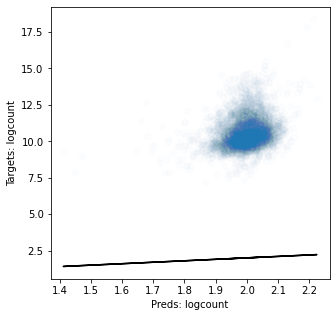

250/250 [==============================] - 106s 424ms/step - loss: 2051.9994 - logcount_loss: 0.4836 - profile_loss: 1810.2123 - val_loss: 1517.6034 - val_logcount_loss: 0.2718 - val_profile_loss: 1381.7017
Epoch 2/200
Scatterplots before epoch 1
logcount SpearmanrResult(correlation=0.19263521804378939, pvalue=1.690378079579855e-41)


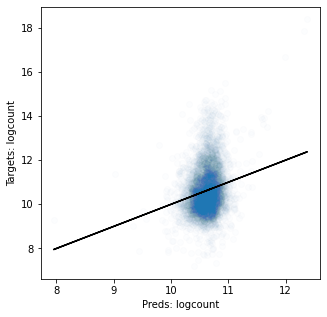

250/250 [==============================] - 87s 347ms/step - loss: 1910.7426 - logcount_loss: 0.3003 - profile_loss: 1760.6104 - val_loss: 1495.8287 - val_logcount_loss: 0.2702 - val_profile_loss: 1360.7167
Epoch 3/200
Scatterplots before epoch 2
logcount SpearmanrResult(correlation=0.2260308750769335, pvalue=7.28874101032933e-57)


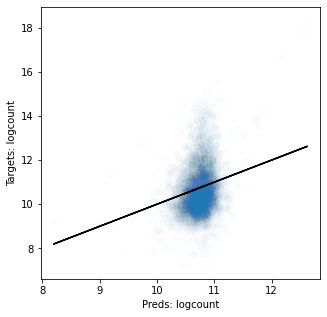

250/250 [==============================] - 87s 347ms/step - loss: 1878.6238 - logcount_loss: 0.2947 - profile_loss: 1731.2507 - val_loss: 1476.2758 - val_logcount_loss: 0.2662 - val_profile_loss: 1343.1956
Epoch 4/200
Scatterplots before epoch 3
logcount SpearmanrResult(correlation=0.2477439356293389, pvalue=2.654174789379862e-68)


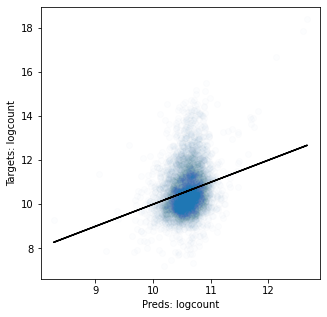

250/250 [==============================] - 87s 350ms/step - loss: 1840.6701 - logcount_loss: 0.2986 - profile_loss: 1691.3945 - val_loss: 1463.5480 - val_logcount_loss: 0.2843 - val_profile_loss: 1321.3754
Epoch 5/200
Scatterplots before epoch 4
logcount SpearmanrResult(correlation=0.26580366144753154, pvalue=1.0204992638400328e-78)


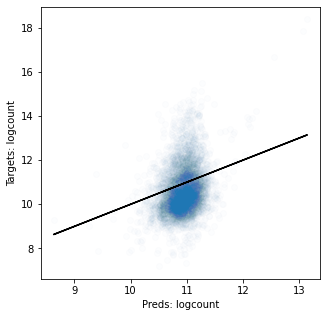

250/250 [==============================] - 87s 349ms/step - loss: 1809.5724 - logcount_loss: 0.3027 - profile_loss: 1658.2149 - val_loss: 1438.1818 - val_logcount_loss: 0.2638 - val_profile_loss: 1306.2594
Epoch 6/200
Scatterplots before epoch 5
logcount SpearmanrResult(correlation=0.2504851056652771, pvalue=7.878154008739255e-70)


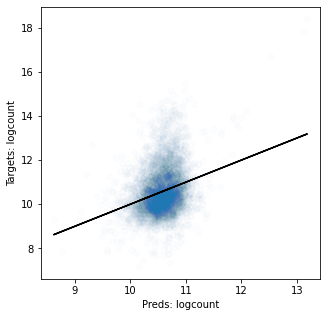

250/250 [==============================] - 87s 348ms/step - loss: 1774.2040 - logcount_loss: 0.2890 - profile_loss: 1629.6925 - val_loss: 1437.5958 - val_logcount_loss: 0.2783 - val_profile_loss: 1298.4449
Epoch 7/200
Scatterplots before epoch 6
logcount SpearmanrResult(correlation=0.26412845911047816, pvalue=1.023362297319356e-77)


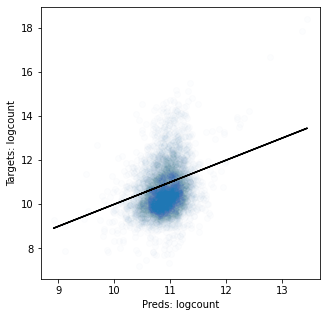

250/250 [==============================] - 87s 347ms/step - loss: 1751.6100 - logcount_loss: 0.2932 - profile_loss: 1604.9977 - val_loss: 1426.8960 - val_logcount_loss: 0.2768 - val_profile_loss: 1288.4807
Epoch 8/200
Scatterplots before epoch 7
logcount SpearmanrResult(correlation=0.2664005769773432, pvalue=4.46993928947251e-79)


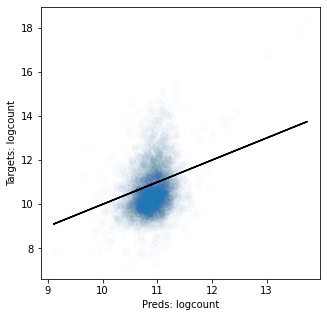

250/250 [==============================] - 87s 349ms/step - loss: 1725.8746 - logcount_loss: 0.2885 - profile_loss: 1581.6238 - val_loss: 1459.1368 - val_logcount_loss: 0.2841 - val_profile_loss: 1317.0634
Epoch 9/200
Scatterplots before epoch 8
logcount SpearmanrResult(correlation=0.24570662899134027, pvalue=3.523496499036661e-67)


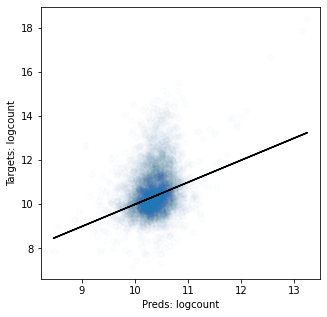

250/250 [==============================] - 87s 348ms/step - loss: 1712.6695 - logcount_loss: 0.2972 - profile_loss: 1564.0582 - val_loss: 1402.4703 - val_logcount_loss: 0.2638 - val_profile_loss: 1270.5602
Epoch 10/200
Scatterplots before epoch 9
logcount SpearmanrResult(correlation=0.27469226549629117, pvalue=3.7534788354562215e-84)


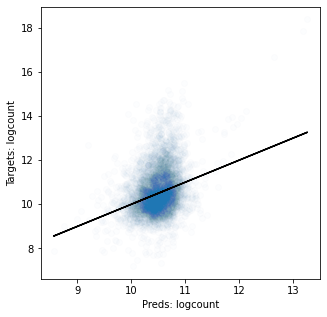

250/250 [==============================] - 87s 348ms/step - loss: 1685.3804 - logcount_loss: 0.2870 - profile_loss: 1541.8988 - val_loss: 1432.7919 - val_logcount_loss: 0.2915 - val_profile_loss: 1287.0386
Epoch 11/200
Scatterplots before epoch 10
logcount SpearmanrResult(correlation=0.2786430537600975, pvalue=1.2375376954761363e-86)


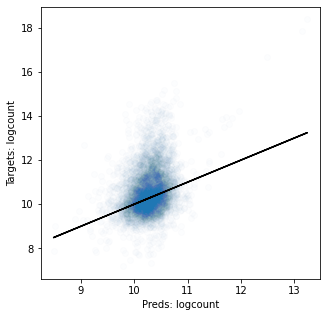

250/250 [==============================] - 87s 349ms/step - loss: 1666.7733 - logcount_loss: 0.2853 - profile_loss: 1524.1012 - val_loss: 1392.8532 - val_logcount_loss: 0.2721 - val_profile_loss: 1256.7822
Epoch 12/200
Scatterplots before epoch 11
logcount SpearmanrResult(correlation=0.2855729447707008, pvalue=4.35878353112075e-91)


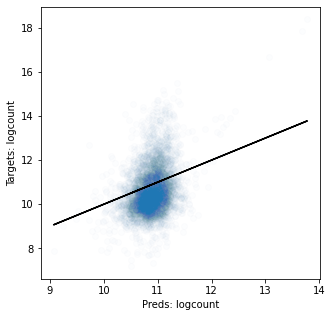

250/250 [==============================] - 88s 351ms/step - loss: 1644.5971 - logcount_loss: 0.2953 - profile_loss: 1496.9570 - val_loss: 1413.8980 - val_logcount_loss: 0.2622 - val_profile_loss: 1282.7994
Epoch 13/200
Scatterplots before epoch 12
logcount SpearmanrResult(correlation=0.2505180044038739, pvalue=7.55051883724369e-70)


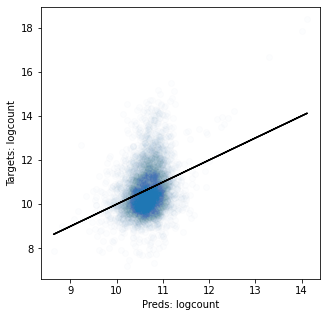

250/250 [==============================] - 87s 349ms/step - loss: 1618.3196 - logcount_loss: 0.2834 - profile_loss: 1476.6028 - val_loss: 1391.3293 - val_logcount_loss: 0.2759 - val_profile_loss: 1253.3677
Epoch 14/200
Scatterplots before epoch 13
logcount SpearmanrResult(correlation=0.27233119826850655, pvalue=1.0916071522137871e-82)


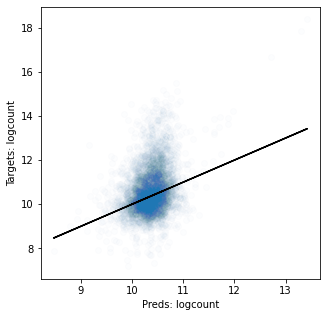

250/250 [==============================] - 87s 348ms/step - loss: 1608.4557 - logcount_loss: 0.3041 - profile_loss: 1456.3984 - val_loss: 1378.9342 - val_logcount_loss: 0.2677 - val_profile_loss: 1245.0635
Epoch 15/200
Scatterplots before epoch 14
logcount SpearmanrResult(correlation=0.26517222824430775, pvalue=2.4381035920749943e-78)


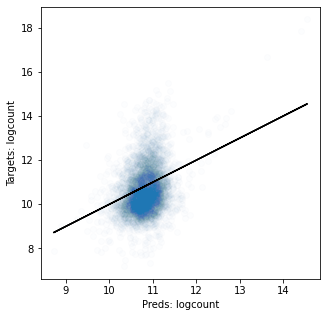

250/250 [==============================] - 88s 351ms/step - loss: 1585.0328 - logcount_loss: 0.2939 - profile_loss: 1438.1030 - val_loss: 1391.7487 - val_logcount_loss: 0.2933 - val_profile_loss: 1245.1009
Epoch 16/200
Scatterplots before epoch 15
logcount SpearmanrResult(correlation=0.26499687994543264, pvalue=3.1038877630715305e-78)


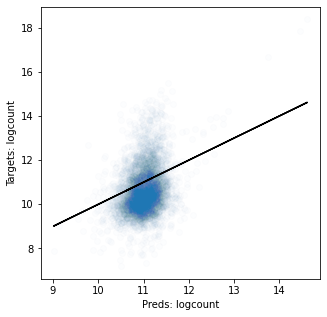

250/250 [==============================] - 87s 350ms/step - loss: 1581.9986 - logcount_loss: 0.2991 - profile_loss: 1432.4420 - val_loss: 1419.8999 - val_logcount_loss: 0.2713 - val_profile_loss: 1284.2546
Epoch 17/200
Scatterplots before epoch 16
logcount SpearmanrResult(correlation=0.23754028355991982, pvalue=8.801314183715951e-63)


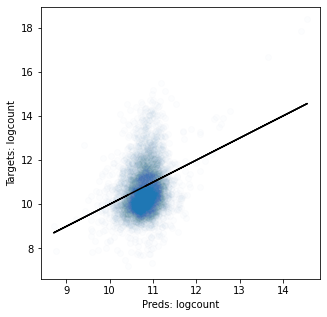

  4/250 [..............................] - ETA: 2:26 - loss: 1268.8488 - logcount_loss: 0.2858 - profile_loss: 1125.9658

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106901). Check your callbacks.
  % delta_t_median)


250/250 [==============================] - 88s 351ms/step - loss: 1595.1726 - logcount_loss: 0.3088 - profile_loss: 1440.7494 - val_loss: 1377.5448 - val_logcount_loss: 0.2656 - val_profile_loss: 1244.7202
Epoch 18/200
Scatterplots before epoch 17
logcount SpearmanrResult(correlation=0.2412924220300338, pvalue=8.803085160397825e-65)


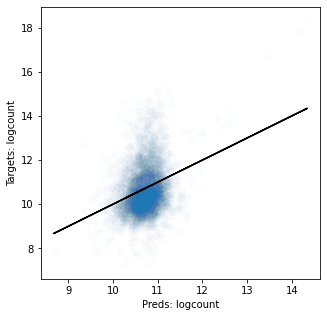

250/250 [==============================] - 87s 350ms/step - loss: 1500.4152 - logcount_loss: 0.2874 - profile_loss: 1356.6937 - val_loss: 1397.8894 - val_logcount_loss: 0.2653 - val_profile_loss: 1265.2567
Epoch 19/200
Scatterplots before epoch 18
logcount SpearmanrResult(correlation=0.23797239788922842, pvalue=5.200037168032568e-63)


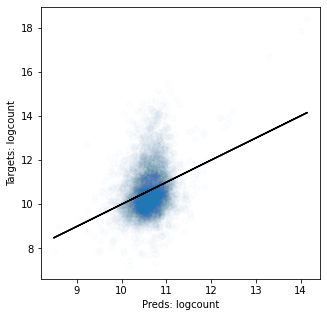

250/250 [==============================] - 88s 351ms/step - loss: 1472.5030 - logcount_loss: 0.2893 - profile_loss: 1327.8617 - val_loss: 1365.8619 - val_logcount_loss: 0.2801 - val_profile_loss: 1225.8080
Epoch 20/200
Scatterplots before epoch 19
logcount SpearmanrResult(correlation=0.24971174912982094, pvalue=2.1344732956162387e-69)


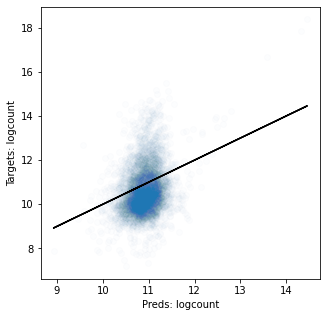

250/250 [==============================] - 88s 351ms/step - loss: 1420.9497 - logcount_loss: 0.2879 - profile_loss: 1277.0076 - val_loss: 1492.1931 - val_logcount_loss: 0.3760 - val_profile_loss: 1304.1840
Epoch 21/200
Scatterplots before epoch 20
logcount SpearmanrResult(correlation=0.2179865157062882, pvalue=6.417157250399828e-53)


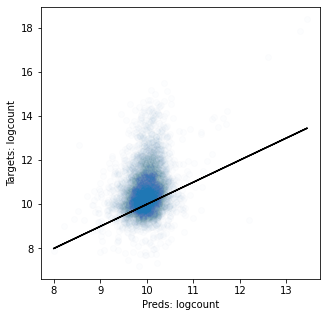

250/250 [==============================] - 88s 351ms/step - loss: 1421.2354 - logcount_loss: 0.2868 - profile_loss: 1277.8140 - val_loss: 1347.7296 - val_logcount_loss: 0.2687 - val_profile_loss: 1213.3726
Epoch 22/200
Scatterplots before epoch 21
logcount SpearmanrResult(correlation=0.25312074056010553, pvalue=2.5694975000909944e-71)


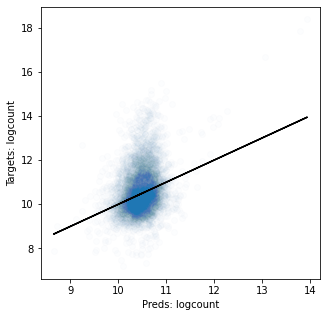

250/250 [==============================] - 89s 355ms/step - loss: 1357.6372 - logcount_loss: 0.2865 - profile_loss: 1214.3992 - val_loss: 1338.0918 - val_logcount_loss: 0.2675 - val_profile_loss: 1204.3548
Epoch 23/200
Scatterplots before epoch 22
logcount SpearmanrResult(correlation=0.25737360617942373, pvalue=9.417922588407854e-74)


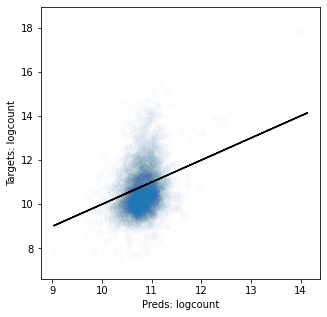

250/250 [==============================] - 88s 352ms/step - loss: 1476.6646 - logcount_loss: 0.2926 - profile_loss: 1330.3843 - val_loss: 1344.0732 - val_logcount_loss: 0.2684 - val_profile_loss: 1209.8896
Epoch 24/200
Scatterplots before epoch 23
logcount SpearmanrResult(correlation=0.2277873821017896, pvalue=9.559522639889946e-58)


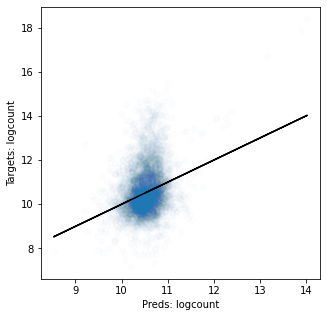

250/250 [==============================] - 88s 353ms/step - loss: 1344.6510 - logcount_loss: 0.2825 - profile_loss: 1203.3829 - val_loss: 1320.4313 - val_logcount_loss: 0.2620 - val_profile_loss: 1189.4141
Epoch 25/200
Scatterplots before epoch 24
logcount SpearmanrResult(correlation=0.25034885021650227, pvalue=9.392893559917737e-70)


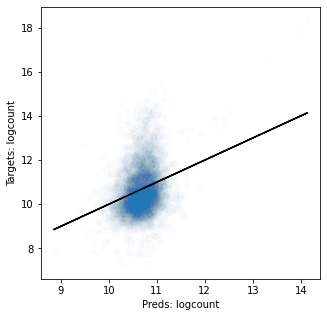

250/250 [==============================] - 88s 353ms/step - loss: 1428.4387 - logcount_loss: 0.2905 - profile_loss: 1283.1836 - val_loss: 1325.6232 - val_logcount_loss: 0.2692 - val_profile_loss: 1191.0360
Epoch 26/200
Scatterplots before epoch 25
logcount SpearmanrResult(correlation=0.26179603486133984, pvalue=2.466014075031088e-76)


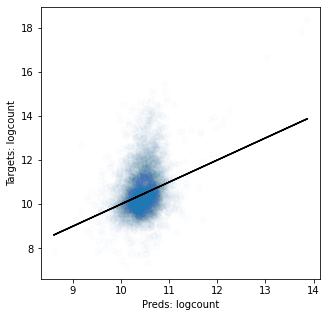

250/250 [==============================] - 89s 355ms/step - loss: 1319.1823 - logcount_loss: 0.2788 - profile_loss: 1179.7806 - val_loss: 1320.9222 - val_logcount_loss: 0.2870 - val_profile_loss: 1177.4204
Epoch 27/200
Scatterplots before epoch 26
logcount SpearmanrResult(correlation=0.2599734269953876, pvalue=2.8984220366125965e-75)


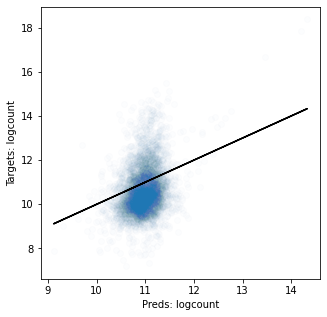

250/250 [==============================] - 88s 352ms/step - loss: 1320.5632 - logcount_loss: 0.2788 - profile_loss: 1181.1499 - val_loss: 1321.1855 - val_logcount_loss: 0.2879 - val_profile_loss: 1177.2536
Epoch 28/200
Scatterplots before epoch 27
logcount SpearmanrResult(correlation=0.27674751707238465, pvalue=1.942954325656464e-85)


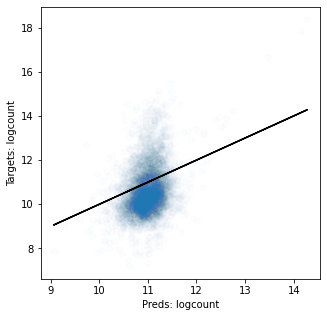

250/250 [==============================] - 89s 356ms/step - loss: 1302.9144 - logcount_loss: 0.2805 - profile_loss: 1162.6589 - val_loss: 1294.6565 - val_logcount_loss: 0.2574 - val_profile_loss: 1165.9797
Epoch 29/200
Scatterplots before epoch 28
logcount SpearmanrResult(correlation=0.2795646145690929, pvalue=3.2189248362933496e-87)


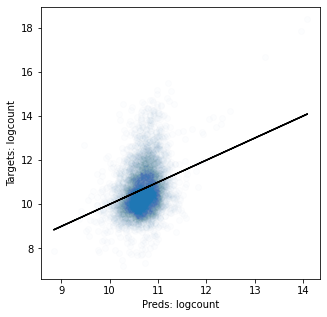

250/250 [==============================] - 89s 357ms/step - loss: 1293.5178 - logcount_loss: 0.2744 - profile_loss: 1156.2992 - val_loss: 1393.3572 - val_logcount_loss: 0.2752 - val_profile_loss: 1255.7399
Epoch 30/200
Scatterplots before epoch 29
logcount SpearmanrResult(correlation=0.2690525986789411, pvalue=1.112534872118328e-80)


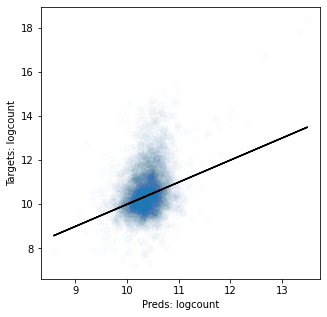

250/250 [==============================] - 88s 354ms/step - loss: 1280.9294 - logcount_loss: 0.2752 - profile_loss: 1143.3397 - val_loss: 1318.0063 - val_logcount_loss: 0.3067 - val_profile_loss: 1164.6751
Epoch 31/200
Scatterplots before epoch 30
logcount SpearmanrResult(correlation=0.27596982669259174, pvalue=5.97544975507003e-85)


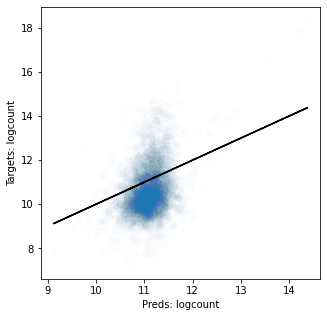

250/250 [==============================] - 89s 354ms/step - loss: 1262.8052 - logcount_loss: 0.2698 - profile_loss: 1127.8838 - val_loss: 1291.8142 - val_logcount_loss: 0.2609 - val_profile_loss: 1161.3450
Epoch 32/200
Scatterplots before epoch 31
logcount SpearmanrResult(correlation=0.3056312248777053, pvalue=1.0459184413716807e-104)


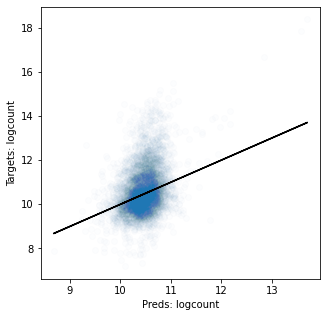

250/250 [==============================] - 89s 357ms/step - loss: 1250.5290 - logcount_loss: 0.2723 - profile_loss: 1114.3562 - val_loss: 1284.4514 - val_logcount_loss: 0.2745 - val_profile_loss: 1147.2022
Epoch 33/200
Scatterplots before epoch 32
logcount SpearmanrResult(correlation=0.3262396177020874, pvalue=7.264839927920682e-120)


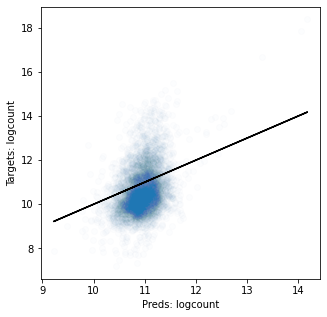

250/250 [==============================] - 89s 356ms/step - loss: 1240.7699 - logcount_loss: 0.2701 - profile_loss: 1105.7167 - val_loss: 1271.6541 - val_logcount_loss: 0.2539 - val_profile_loss: 1144.7025
Epoch 34/200
Scatterplots before epoch 33
logcount SpearmanrResult(correlation=0.30824280816934696, pvalue=1.461694778073964e-106)


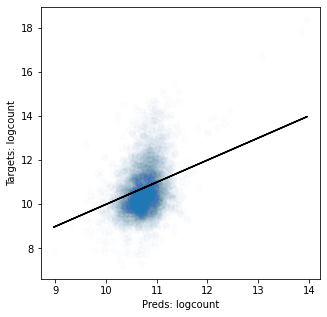

250/250 [==============================] - 89s 356ms/step - loss: 1223.3712 - logcount_loss: 0.2647 - profile_loss: 1091.0324 - val_loss: 1263.3963 - val_logcount_loss: 0.2490 - val_profile_loss: 1138.9018
Epoch 35/200
Scatterplots before epoch 34
logcount SpearmanrResult(correlation=0.33428291784391845, pvalue=4.114834083885434e-126)


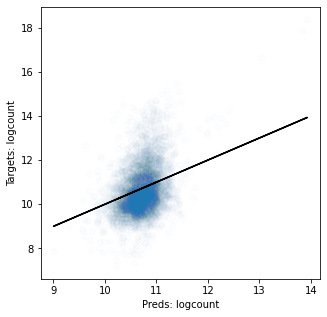

250/250 [==============================] - 89s 355ms/step - loss: 1227.1396 - logcount_loss: 0.2720 - profile_loss: 1091.1171 - val_loss: 1258.9663 - val_logcount_loss: 0.2487 - val_profile_loss: 1134.6349
Epoch 36/200
Scatterplots before epoch 35
logcount SpearmanrResult(correlation=0.3270006711514466, pvalue=1.8976623527888753e-120)


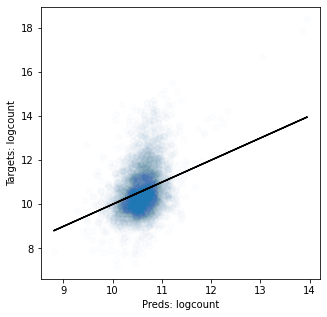

250/250 [==============================] - 89s 358ms/step - loss: 1221.4427 - logcount_loss: 0.2622 - profile_loss: 1090.3349 - val_loss: 1257.1995 - val_logcount_loss: 0.2482 - val_profile_loss: 1133.0887
Epoch 37/200
Scatterplots before epoch 36
logcount SpearmanrResult(correlation=0.3415515262327025, pvalue=6.389084778944075e-132)


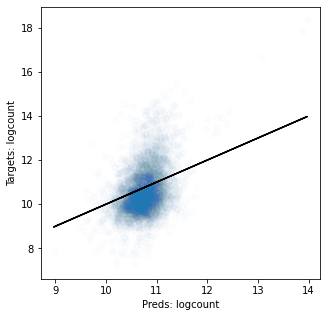

250/250 [==============================] - 89s 356ms/step - loss: 1257.1769 - logcount_loss: 0.2645 - profile_loss: 1124.9021 - val_loss: 1263.4065 - val_logcount_loss: 0.2499 - val_profile_loss: 1138.4719
Epoch 38/200
Scatterplots before epoch 37
logcount SpearmanrResult(correlation=0.3349533233372372, pvalue=1.216537428914236e-126)


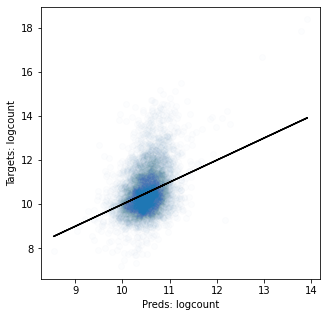

  4/250 [..............................] - ETA: 2:24 - loss: 1130.1069 - logcount_loss: 0.2429 - profile_loss: 1008.6411

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122824). Check your callbacks.
  % delta_t_median)


250/250 [==============================] - 89s 356ms/step - loss: 1208.2895 - logcount_loss: 0.2602 - profile_loss: 1078.1882 - val_loss: 1242.5198 - val_logcount_loss: 0.2404 - val_profile_loss: 1122.3389
Epoch 39/200
Scatterplots before epoch 38
logcount SpearmanrResult(correlation=0.3630119418696258, pvalue=5.289229855174786e-150)


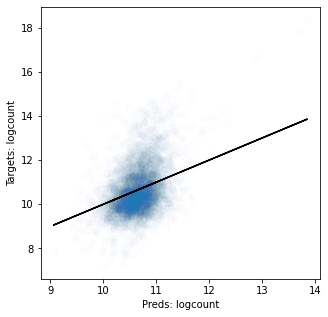

250/250 [==============================] - 89s 357ms/step - loss: 1216.1259 - logcount_loss: 0.2565 - profile_loss: 1087.8734 - val_loss: 1246.0571 - val_logcount_loss: 0.2586 - val_profile_loss: 1116.7472
Epoch 40/200
Scatterplots before epoch 39
logcount SpearmanrResult(correlation=0.37062333034865735, pvalue=9.262566855500821e-157)


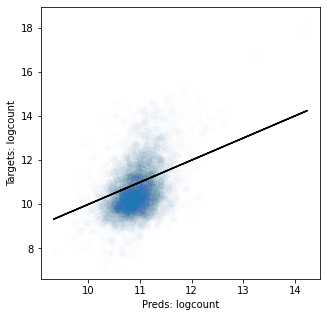

250/250 [==============================] - 90s 358ms/step - loss: 1184.6087 - logcount_loss: 0.2546 - profile_loss: 1057.3299 - val_loss: 1232.0283 - val_logcount_loss: 0.2396 - val_profile_loss: 1112.2138
Epoch 41/200
Scatterplots before epoch 40
logcount SpearmanrResult(correlation=0.3677869573122339, pvalue=3.206574139628557e-154)


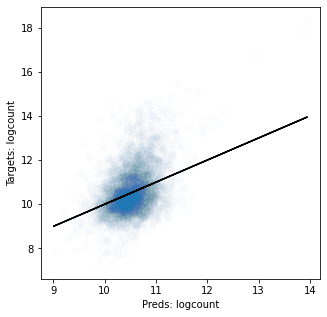

250/250 [==============================] - 89s 357ms/step - loss: 1176.2240 - logcount_loss: 0.2468 - profile_loss: 1052.8490 - val_loss: 1228.8646 - val_logcount_loss: 0.2422 - val_profile_loss: 1107.7750
Epoch 42/200
Scatterplots before epoch 41
logcount SpearmanrResult(correlation=0.38391248201191, pvalue=5.300512670823346e-169)


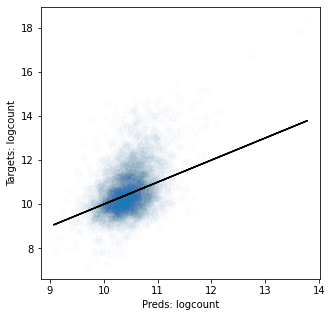

250/250 [==============================] - 90s 359ms/step - loss: 1164.4104 - logcount_loss: 0.2397 - profile_loss: 1044.5595 - val_loss: 1227.7886 - val_logcount_loss: 0.2330 - val_profile_loss: 1111.2935
Epoch 43/200
Scatterplots before epoch 42
logcount SpearmanrResult(correlation=0.3755825413888514, pvalue=2.917947337010076e-161)


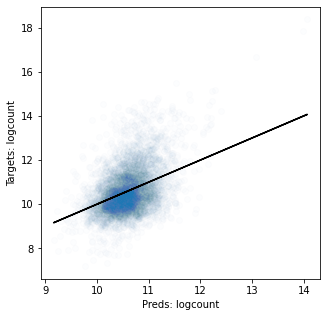

250/250 [==============================] - 90s 360ms/step - loss: 1197.3836 - logcount_loss: 0.2463 - profile_loss: 1074.2582 - val_loss: 1235.4983 - val_logcount_loss: 0.2461 - val_profile_loss: 1112.4595
Epoch 44/200
Scatterplots before epoch 43
logcount SpearmanrResult(correlation=0.3580141308352571, pvalue=1.150588757500343e-145)


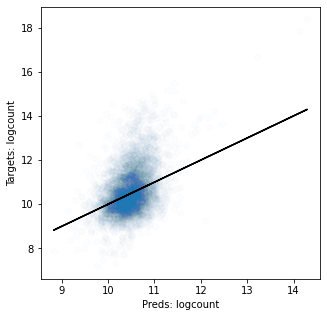

250/250 [==============================] - 90s 359ms/step - loss: 1190.1978 - logcount_loss: 0.2447 - profile_loss: 1067.8245 - val_loss: 1221.7182 - val_logcount_loss: 0.2317 - val_profile_loss: 1105.8602
Epoch 45/200
Scatterplots before epoch 44
logcount SpearmanrResult(correlation=0.38007897724512574, pvalue=2.064533579751938e-165)


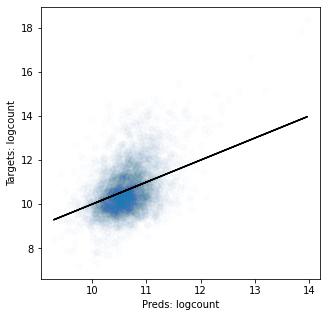

250/250 [==============================] - 91s 363ms/step - loss: 1210.4035 - logcount_loss: 0.2349 - profile_loss: 1092.9398 - val_loss: 1213.9827 - val_logcount_loss: 0.2335 - val_profile_loss: 1097.2213
Epoch 46/200
Scatterplots before epoch 45
logcount SpearmanrResult(correlation=0.38210760297894564, pvalue=2.635108030453425e-167)


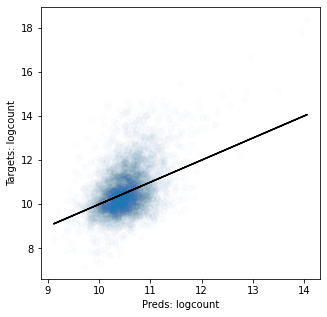

250/250 [==============================] - 90s 361ms/step - loss: 1166.7271 - logcount_loss: 0.2275 - profile_loss: 1052.9833 - val_loss: 1215.4842 - val_logcount_loss: 0.2432 - val_profile_loss: 1093.8685
Epoch 47/200
Scatterplots before epoch 46
logcount SpearmanrResult(correlation=0.3819577787159401, pvalue=3.640348559736431e-167)


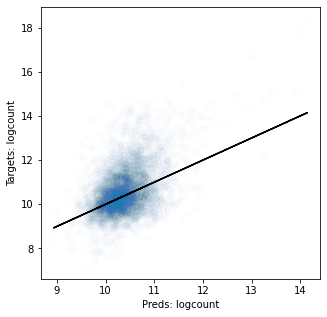

250/250 [==============================] - 90s 362ms/step - loss: 1144.5218 - logcount_loss: 0.2209 - profile_loss: 1034.0488 - val_loss: 1201.9740 - val_logcount_loss: 0.2237 - val_profile_loss: 1090.1328
Epoch 48/200
Scatterplots before epoch 47
logcount SpearmanrResult(correlation=0.4012640480658702, pvalue=7.2356447685385696e-186)


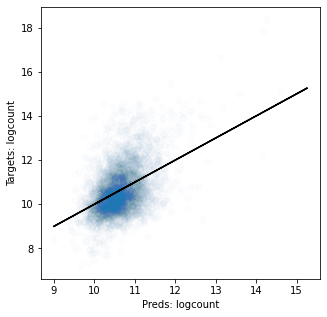

  3/250 [..............................] - ETA: 3:02 - loss: 1133.5898 - logcount_loss: 0.2287 - profile_loss: 1019.2342

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119839). Check your callbacks.
  % delta_t_median)


250/250 [==============================] - 90s 360ms/step - loss: 1135.9524 - logcount_loss: 0.2230 - profile_loss: 1024.4300 - val_loss: 1201.2052 - val_logcount_loss: 0.2258 - val_profile_loss: 1088.3177
Epoch 49/200
Scatterplots before epoch 48
logcount SpearmanrResult(correlation=0.3853140536105858, pvalue=2.5090750971455624e-170)


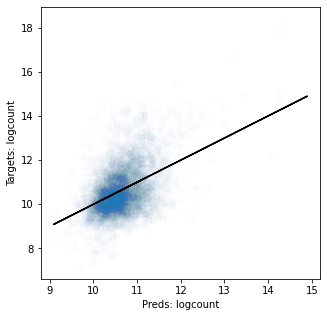

250/250 [==============================] - 90s 359ms/step - loss: 1136.3619 - logcount_loss: 0.2206 - profile_loss: 1026.0754 - val_loss: 1200.6246 - val_logcount_loss: 0.2274 - val_profile_loss: 1086.9324
Epoch 50/200
Scatterplots before epoch 49
logcount SpearmanrResult(correlation=0.3736422265532371, pvalue=1.7210127198622078e-159)


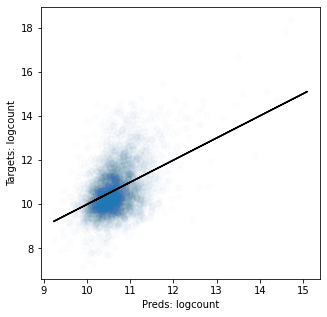

250/250 [==============================] - 92s 367ms/step - loss: 1146.9597 - logcount_loss: 0.2229 - profile_loss: 1035.5105 - val_loss: 1210.9530 - val_logcount_loss: 0.2354 - val_profile_loss: 1093.2355
Epoch 51/200
Scatterplots before epoch 50
logcount SpearmanrResult(correlation=0.378717332746478, pvalue=3.789428146123725e-164)


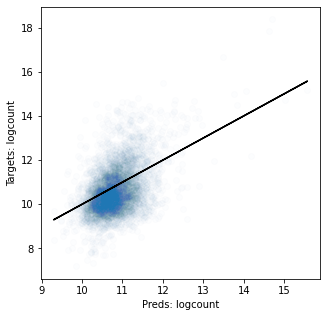

250/250 [==============================] - 92s 367ms/step - loss: 1176.4698 - logcount_loss: 0.2211 - profile_loss: 1065.9159 - val_loss: 1198.4102 - val_logcount_loss: 0.2266 - val_profile_loss: 1085.1062
Epoch 52/200
Scatterplots before epoch 51
logcount SpearmanrResult(correlation=0.38622154909210094, pvalue=3.4534839261084365e-171)


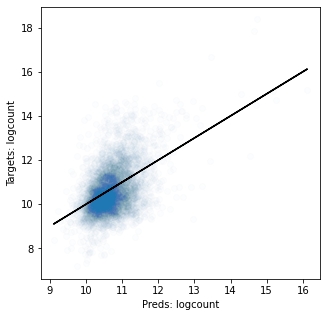

250/250 [==============================] - 94s 375ms/step - loss: 1138.2893 - logcount_loss: 0.2148 - profile_loss: 1030.8719 - val_loss: 1197.2974 - val_logcount_loss: 0.2304 - val_profile_loss: 1082.0948
Epoch 53/200
Scatterplots before epoch 52
logcount SpearmanrResult(correlation=0.40341143315769706, pvalue=5.024473393090048e-188)


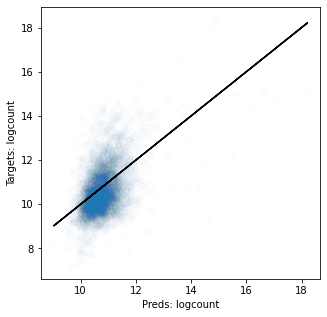

250/250 [==============================] - 93s 371ms/step - loss: 1124.3433 - logcount_loss: 0.2124 - profile_loss: 1018.1424 - val_loss: 1191.1689 - val_logcount_loss: 0.2253 - val_profile_loss: 1078.5235
Epoch 54/200
Scatterplots before epoch 53
logcount SpearmanrResult(correlation=0.40196233586310126, pvalue=1.4433123594500794e-186)


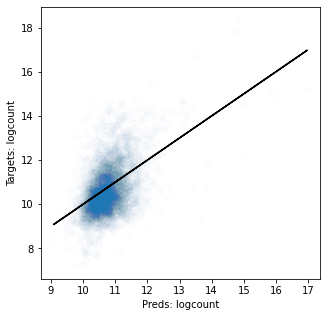

250/250 [==============================] - 92s 369ms/step - loss: 1116.4086 - logcount_loss: 0.2083 - profile_loss: 1012.2633 - val_loss: 1194.4967 - val_logcount_loss: 0.2307 - val_profile_loss: 1079.1467
Epoch 55/200
Scatterplots before epoch 54
logcount SpearmanrResult(correlation=0.4108541515441722, pvalue=1.2472241366400663e-195)


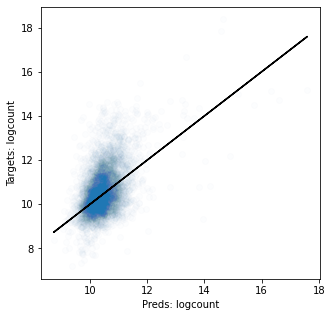

250/250 [==============================] - 92s 369ms/step - loss: 1116.3289 - logcount_loss: 0.2124 - profile_loss: 1010.1064 - val_loss: 1194.8360 - val_logcount_loss: 0.2365 - val_profile_loss: 1076.5782
Epoch 56/200
Scatterplots before epoch 55
logcount SpearmanrResult(correlation=0.39456263793883245, pvalue=3.1146844906819725e-179)


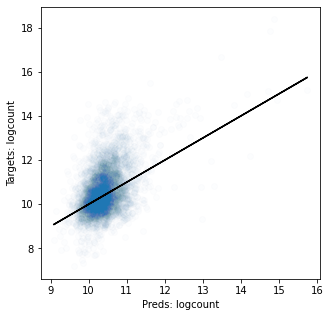

250/250 [==============================] - 92s 367ms/step - loss: 1116.8015 - logcount_loss: 0.2094 - profile_loss: 1012.1069 - val_loss: 1188.9455 - val_logcount_loss: 0.2299 - val_profile_loss: 1073.9931
Epoch 57/200
Scatterplots before epoch 56
logcount SpearmanrResult(correlation=0.3916482284412689, pvalue=2.1421584723358083e-176)


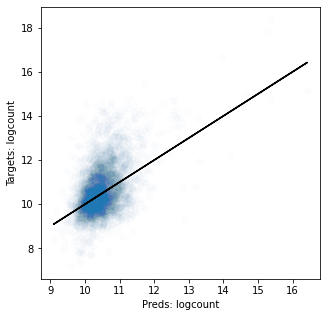

250/250 [==============================] - 90s 361ms/step - loss: 1120.1337 - logcount_loss: 0.2099 - profile_loss: 1015.1967 - val_loss: 1194.0298 - val_logcount_loss: 0.2281 - val_profile_loss: 1079.9578
Epoch 58/200
Scatterplots before epoch 57
logcount SpearmanrResult(correlation=0.40053954355193566, pvalue=3.8379815106269467e-185)


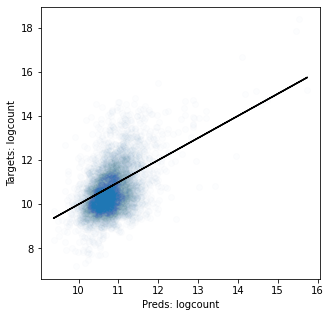

250/250 [==============================] - 89s 357ms/step - loss: 1133.1237 - logcount_loss: 0.2079 - profile_loss: 1029.1565 - val_loss: 1186.0175 - val_logcount_loss: 0.2215 - val_profile_loss: 1075.2775
Epoch 59/200
Scatterplots before epoch 58
logcount SpearmanrResult(correlation=0.41027101686045986, pvalue=4.998351361921783e-195)


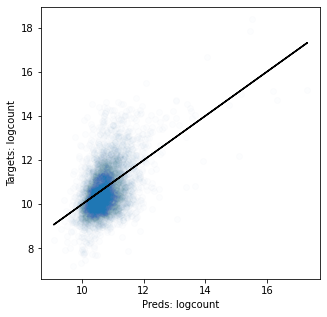

250/250 [==============================] - 91s 363ms/step - loss: 1114.5880 - logcount_loss: 0.2087 - profile_loss: 1010.2621 - val_loss: 1184.9774 - val_logcount_loss: 0.2228 - val_profile_loss: 1073.5761
Epoch 60/200
Scatterplots before epoch 59
logcount SpearmanrResult(correlation=0.39199538262581685, pvalue=9.871172871684875e-177)


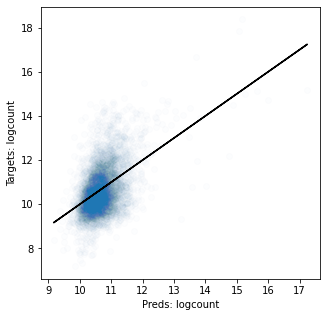

250/250 [==============================] - 90s 360ms/step - loss: 1109.8912 - logcount_loss: 0.2048 - profile_loss: 1007.4662 - val_loss: 1180.1543 - val_logcount_loss: 0.2185 - val_profile_loss: 1070.8842
Epoch 61/200
Scatterplots before epoch 60
logcount SpearmanrResult(correlation=0.4022667944063959, pvalue=7.138012497757199e-187)


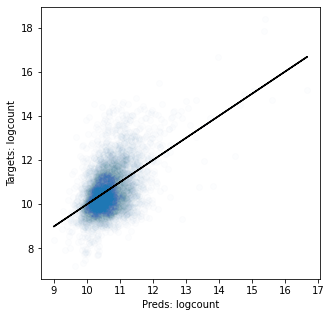

250/250 [==============================] - 90s 361ms/step - loss: 1108.3609 - logcount_loss: 0.2016 - profile_loss: 1007.5451 - val_loss: 1178.7130 - val_logcount_loss: 0.2208 - val_profile_loss: 1068.3069
Epoch 62/200
Scatterplots before epoch 61
logcount SpearmanrResult(correlation=0.41151935930631045, pvalue=2.5511829265741625e-196)


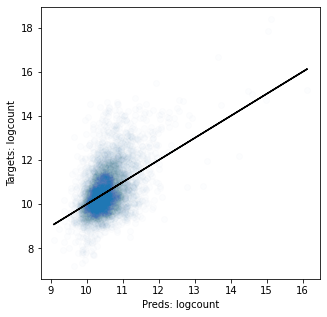

250/250 [==============================] - 91s 362ms/step - loss: 1104.8888 - logcount_loss: 0.1986 - profile_loss: 1005.6112 - val_loss: 1181.9722 - val_logcount_loss: 0.2228 - val_profile_loss: 1070.5677
Epoch 63/200
Scatterplots before epoch 62
logcount SpearmanrResult(correlation=0.4078609594770361, pvalue=1.505868661792982e-192)


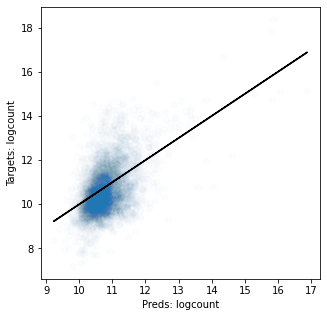

250/250 [==============================] - 92s 368ms/step - loss: 1108.7156 - logcount_loss: 0.1977 - profile_loss: 1009.8573 - val_loss: 1186.8530 - val_logcount_loss: 0.2363 - val_profile_loss: 1068.6888
Epoch 64/200
Scatterplots before epoch 63
logcount SpearmanrResult(correlation=0.4010466353521691, pvalue=1.1943075140897703e-185)


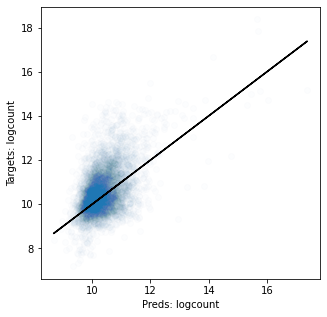

250/250 [==============================] - 90s 362ms/step - loss: 1101.0673 - logcount_loss: 0.1962 - profile_loss: 1002.9567 - val_loss: 1175.0900 - val_logcount_loss: 0.2164 - val_profile_loss: 1066.8714
Epoch 65/200
Scatterplots before epoch 64
logcount SpearmanrResult(correlation=0.41493040187927904, pvalue=7.046456245993836e-200)


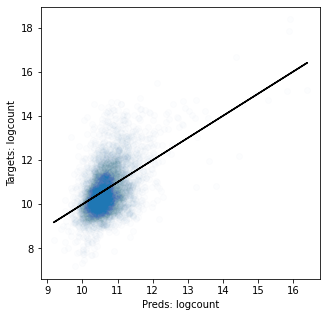

250/250 [==============================] - 90s 360ms/step - loss: 1098.7192 - logcount_loss: 0.1972 - profile_loss: 1000.1281 - val_loss: 1175.5689 - val_logcount_loss: 0.2194 - val_profile_loss: 1065.8780
Epoch 66/200
Scatterplots before epoch 65
logcount SpearmanrResult(correlation=0.4035592816412327, pvalue=3.5636696737990763e-188)


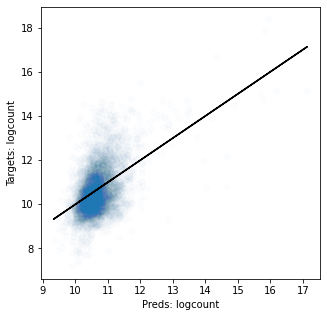

250/250 [==============================] - 91s 363ms/step - loss: 1098.9193 - logcount_loss: 0.1922 - profile_loss: 1002.8381 - val_loss: 1178.5220 - val_logcount_loss: 0.2251 - val_profile_loss: 1065.9528
Epoch 67/200
Scatterplots before epoch 66
logcount SpearmanrResult(correlation=0.4115902922750709, pvalue=2.1535627547343977e-196)


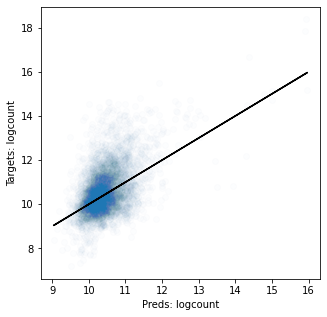

250/250 [==============================] - 91s 364ms/step - loss: 1105.0484 - logcount_loss: 0.1925 - profile_loss: 1008.7778 - val_loss: 1182.7326 - val_logcount_loss: 0.2351 - val_profile_loss: 1065.1940
Epoch 68/200
Scatterplots before epoch 67
logcount SpearmanrResult(correlation=0.4022532456755443, pvalue=7.365322795085898e-187)


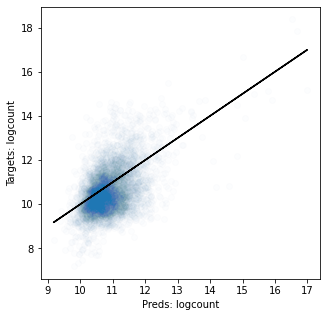

250/250 [==============================] - 91s 364ms/step - loss: 1101.8684 - logcount_loss: 0.1905 - profile_loss: 1006.6125 - val_loss: 1173.9024 - val_logcount_loss: 0.2156 - val_profile_loss: 1066.0872
Epoch 69/200
Scatterplots before epoch 68
logcount SpearmanrResult(correlation=0.4218029819047466, pvalue=3.556437654046177e-207)


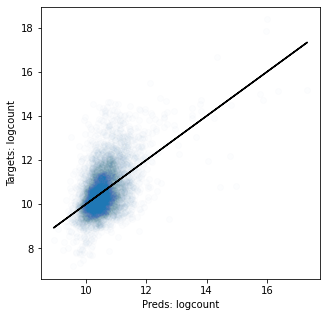

250/250 [==============================] - 91s 363ms/step - loss: 1096.2187 - logcount_loss: 0.1854 - profile_loss: 1003.5354 - val_loss: 1172.5812 - val_logcount_loss: 0.2164 - val_profile_loss: 1064.3867
Epoch 70/200
Scatterplots before epoch 69
logcount SpearmanrResult(correlation=0.4175941081153653, pvalue=1.0964729600489233e-202)


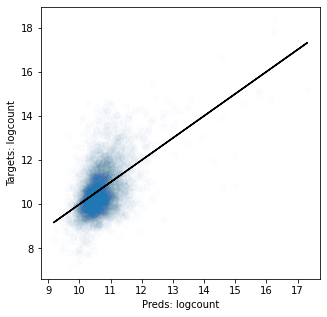

250/250 [==============================] - 91s 364ms/step - loss: 1091.4208 - logcount_loss: 0.1856 - profile_loss: 998.6293 - val_loss: 1170.1136 - val_logcount_loss: 0.2126 - val_profile_loss: 1063.8014
Epoch 71/200
Scatterplots before epoch 70
logcount SpearmanrResult(correlation=0.42928824268388177, pvalue=2.5565737288302845e-215)


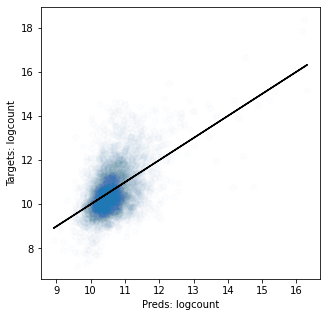

250/250 [==============================] - 91s 365ms/step - loss: 1088.6595 - logcount_loss: 0.1796 - profile_loss: 998.8792 - val_loss: 1173.2913 - val_logcount_loss: 0.2188 - val_profile_loss: 1063.9094
Epoch 72/200
Scatterplots before epoch 71
logcount SpearmanrResult(correlation=0.41097010367958214, pvalue=9.460682281107209e-196)


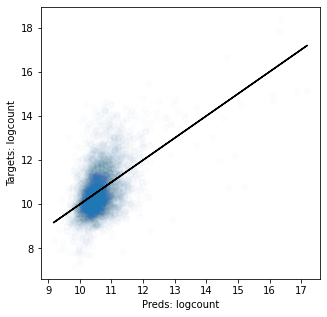

250/250 [==============================] - 92s 366ms/step - loss: 1090.6745 - logcount_loss: 0.1811 - profile_loss: 1000.1251 - val_loss: 1178.7384 - val_logcount_loss: 0.2264 - val_profile_loss: 1065.5394
Epoch 73/200
Scatterplots before epoch 72
logcount SpearmanrResult(correlation=0.4137980265482479, pvalue=1.0813873867719534e-198)


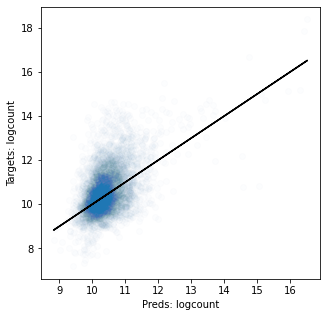

250/250 [==============================] - 91s 364ms/step - loss: 1093.7073 - logcount_loss: 0.1776 - profile_loss: 1004.9299 - val_loss: 1175.0360 - val_logcount_loss: 0.2242 - val_profile_loss: 1062.9563
Epoch 74/200
Scatterplots before epoch 73
logcount SpearmanrResult(correlation=0.402934793397284, pvalue=1.5189706854346177e-187)


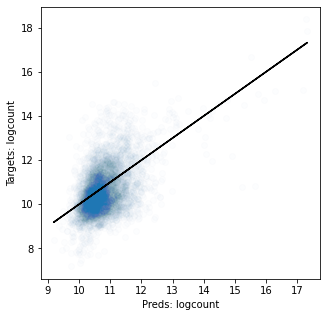

250/250 [==============================] - 91s 364ms/step - loss: 1085.8466 - logcount_loss: 0.1752 - profile_loss: 998.2495 - val_loss: 1173.1285 - val_logcount_loss: 0.2209 - val_profile_loss: 1062.6891
Epoch 75/200
Scatterplots before epoch 74
logcount SpearmanrResult(correlation=0.40875481211232967, pvalue=1.8229019395382894e-193)


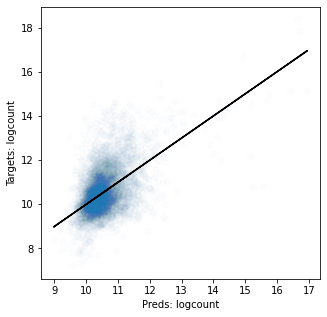

250/250 [==============================] - 91s 364ms/step - loss: 1082.7634 - logcount_loss: 0.1733 - profile_loss: 996.1360 - val_loss: 1175.3806 - val_logcount_loss: 0.2277 - val_profile_loss: 1061.5237
Epoch 76/200
Scatterplots before epoch 75
logcount SpearmanrResult(correlation=0.41660767948664934, pvalue=1.2100985085711723e-201)


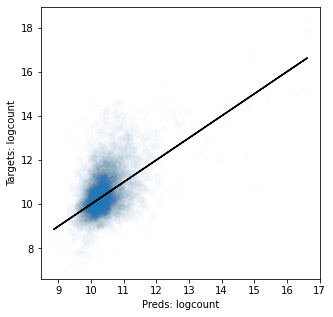

250/250 [==============================] - 91s 365ms/step - loss: 1077.6392 - logcount_loss: 0.1659 - profile_loss: 994.7035 - val_loss: 1174.9458 - val_logcount_loss: 0.2277 - val_profile_loss: 1061.0842
Epoch 77/200
Scatterplots before epoch 76
logcount SpearmanrResult(correlation=0.4125784323243155, pvalue=2.0240941385956693e-197)


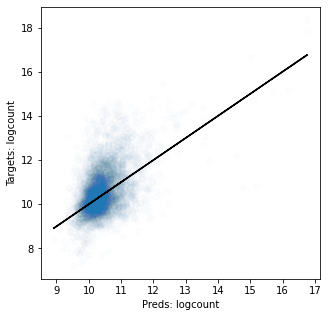

250/250 [==============================] - 92s 366ms/step - loss: 1078.3609 - logcount_loss: 0.1646 - profile_loss: 996.0561 - val_loss: 1175.3975 - val_logcount_loss: 0.2238 - val_profile_loss: 1063.4967
Epoch 78/200
Scatterplots before epoch 77
logcount SpearmanrResult(correlation=0.4034403113627073, pvalue=4.6984614223187195e-188)


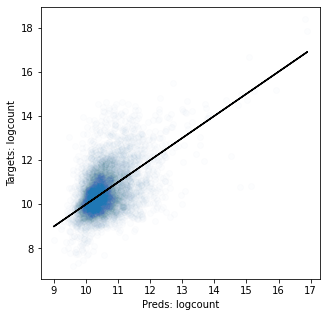

250/250 [==============================] - 91s 364ms/step - loss: 1080.5739 - logcount_loss: 0.1633 - profile_loss: 998.9184 - val_loss: 1175.6652 - val_logcount_loss: 0.2304 - val_profile_loss: 1060.4717
Epoch 79/200
Scatterplots before epoch 78
logcount SpearmanrResult(correlation=0.4006021520934426, pvalue=3.323190279862633e-185)


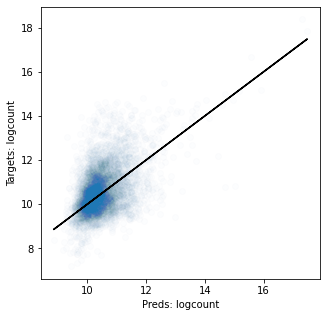

250/250 [==============================] - 91s 364ms/step - loss: 1074.9043 - logcount_loss: 0.1540 - profile_loss: 997.8965 - val_loss: 1192.5816 - val_logcount_loss: 0.2558 - val_profile_loss: 1064.6765
Epoch 80/200
Scatterplots before epoch 79
logcount SpearmanrResult(correlation=0.395719491605055, pvalue=2.2863743234397823e-180)


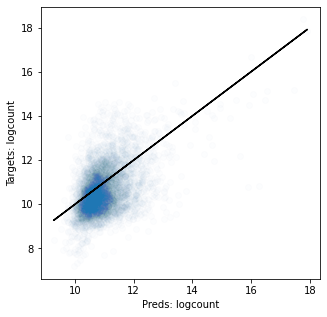

250/250 [==============================] - 91s 363ms/step - loss: 1076.6249 - logcount_loss: 0.1541 - profile_loss: 999.5513 - val_loss: 1173.4322 - val_logcount_loss: 0.2228 - val_profile_loss: 1062.0486


In [12]:
counts_loss, c_task_weight = ("mse", 500)

modelwrapper = BPnetArch(
    counts_loss=counts_loss,
    input_seq_len=seq_len,
    counts_hiddenlayer_size=100,
    c_task_weight=c_task_weight,
    filters=64, n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=75,
    lr=0.001)

class PlotScatter(keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs=None):
        print("Scatterplots before epoch",epoch)
        valid_preds = dict(zip(model.output_names, model.predict(valid_concat_inputs)))
        plot_scatter(preds=valid_preds, targets=valid_concat_targets,
                     keys=['logcount'])

model = modelwrapper.get_keras_model()
print(model.summary())
early_stopping_callback = keras.callbacks.EarlyStopping(
                            patience=10, restore_best_weights=True)
loss_history = model.fit_generator(
                    keras_train_batch_generator,
                    epochs=200,
                    validation_data=keras_valid_batch_generator,
                    callbacks=[early_stopping_callback,
                               PlotScatter()],
                    workers=1)
model.set_weights(early_stopping_callback.best_weights)

In [15]:
!zcat bpnet_Oct4_valid_1k_around_summits.bed.gz | wc -l

4818
